In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import skimage.io
import scipy.signal
from jupyter_compare_view import compare
import warnings
from bm3d import rgb_to
from functools import partial
from pycsou.runtime import Precision, Width
import cupy as cp
from pycsou.util import get_array_module, to_NUMPY
from pycsou.runtime import enforce_precision
from pycsou.abc import LinOp
from pycsou.operator.interop import from_pytorch, from_sciop, from_source
import cupyx.scipy.signal
import scipy.signal
import torch
from pycsou.operator.interop.pytorch import _TorchWrapper
from pycsou.abc import DiffMap, Map, DiffFunc, LinOp
from pycsou.operator import SquaredL2Norm
import time as t

warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.grid"] = False
plt.rcParams["image.cmap"] = "viridis"

rng = np.random.default_rng(seed=0)


def monochromatic(im, chan=0):
    out = im.copy()
    xp = get_array_module(im)
    mask = xp.ones(im.shape, dtype=bool)
    mask[chan] = False
    out[mask] = 0
    return out


def imshow(im, rgb=False):
    im = to_NUMPY(im)
    if im.ndim > 2 and rgb:
        plt.subplot(2, 2, 1)
        plt.imshow(np.moveaxis(im, 0, -1))
        plt.subplot(2, 2, 2)
        plt.imshow(np.moveaxis(monochromatic(im, 0), 0, -1))
        plt.subplot(2, 2, 3)
        plt.imshow(np.moveaxis(monochromatic(im, 1), 0, -1))
        plt.subplot(2, 2, 4)
        plt.imshow(np.moveaxis(monochromatic(im, 2), 0, -1))
    elif im.ndim > 2 and not rgb:
        plt.imshow(np.moveaxis(im, 0, -1))
    else:
        plt.imshow(im, cmap="gray")
    plt.axis("off")


def imshow_compare(*images, **kwargs):
    images = [to_NUMPY(im) for im in images]
    images = [np.clip(im, 0, 1) for im in images]
    images = [np.moveaxis(im, 0, -1) if im.ndim > 2 else im for im in images]
    return compare(
        *images,
        cmap="gray",
        height=700,
        add_controls=True,
        display_format="jpg",
        **kwargs
    )


warnings.filterwarnings("ignore")

<p align="center">
<img src="https://matthieumeo.github.io/pycsou/html/_images/pycsou.png" alt= “” width=65%>
</p>

# A High Performance Computational Imaging Framework for Python

## The ``Pycsou`` Framework

[Pycsou](https://github.com/matthieumeo/pycsou) is an *open-source computational imaging software framework* for Python 3 with native support for *hardware acceleration* and *distributed computing*. The latter adopts a modular and interoperable *microservice architecture* providing **highly optimised and scalable** general-purpose computational imaging functionalities and tools, easy to **reuse and share across imaging modalities**. 

These include notably:
* a rich collection of matrix-free sensing operators and cost/penalty functionals, which can easily be combined via an **advanced operator algebra logic**,
* a complete base class hierarchy for implementing new, custom operators, 
* a comprehensive algorithmic suite featuring *generic* and *plug-and-play* state-of-the-art proximal methods,
* a *test suite* performing extensive **logical and functional** testing of Pycsou components.   

<p align="center">
<img src="doc/images/pycsou_uml2.png" alt= “” width=65%>
</p>

## Matrix-Free Operators

Operators in Pycsou are **mostly** matrix-free, that is they are defined implicitly via their methods defining forward/backward evaluation, differentiation or proximation. For example, linear operators are defined via the ``apply()`` and ``adjoint()`` methods and **not** via their matrix representation: 

```python
class Sum(LinOp):
    
    def apply(self, arr):
        return arr.sum()
    
    def adjoint(self, arr):
        return arr * np.ones(self.shape[0])
```

Matrix-free operators are much more **scalable** (no need to store a huge matrix unecessarily). All methods from the ``LinOp`` base class are matrix-free compatible (e.g., ``lipschitz()``, ``svdvals()``, ``trace()``).

 It is also possible to work with non matrix-free operators via the ``from_array()`` method, which supports a variety of array formats (e.g., ``numpy``, ``cupy``, ``sparse``, ``dask``):
```python
>> op = pyca.LinOp.from_array(np.ones((N, N)))
```

## Operator Algebra Logic

Complex operators can be constructed by composing Pycsou's fundamental building blocks via the following set of arithmetic operations:

```python
>> op1 + op2 # Addition of two operators
>> op1 * op2 # Composition of two operators
>> op ** 3   # Exponentiation of an operator
>> op.argscale(c), op.argshift(x) # Dilation/shifting
>> 4 * op # Scaling
```
In each case, the type of the output is automatically determined from the set of properties of both operators preserved by the arithmetic operation with all methods inferred from those of the operands. 

In particular, the methods``apply()``, ``jacobian()``, ``grad()``, ``prox()``, ``adjoint()`` are updated via chain rules, allowing users to use the composite operators in proximal gradient algorithms without having to worry about implementing gradients/proximal steps.

For example, composing a ``DiffFunc`` with a ``DiffMap`` results in a ``DiffFunc`` with ``grad()`` given by: 

```python
>> h = f * L
>> h.grad(x) = L.jacobian(x).adjoint(f.grad(L(x)))
```

It is also possible to define block-operators via ``coo_block`` (or higher-level functions ``block``, ``block_diag``, ``stack`` ``vstack``, ``hstack``):
```python
>> coo_block(([A(500,1000), B(1,1000), C(500,500), D(1,3)],  # data
   ...      [[0, 1, 0, 2],  # i
   ...       [0, 0, 2, 1],  # j
            ]),grid_shape=(3, 3))
```

| coarse_idx |      0       |    1    |      2      |
|------------|--------------|---------|-------------|
|          0 | A(500, 1000) |         | C(500, 500) |
|          1 | B(1, 1000)   |         |             |
|          2 |              | D(1, 3) |             |

For example, the following functional: 

$$ h(x) = \sum_{i=1}^3 f_i(K_ix)$$

can be easily be constructed from block operations via:

```python
f = hstack([f_1, f_2, f_3]) * vstack([K_1, K_2, K_3])
```
Again, the output type and methods/attributes of the block-operator are inferred automatically from those of the blocks.

## Lipschitz constants

Pycsou operators all come with (not necessarily tight) Lipschitz/diff-Lipschitz constants which can be accessed via the methods ``lipschitz()`` and ``diff_lipschitz()`` respectively. This is useful for automatically choosing suitable step sizes in optimisation algorithms (done under the hood by Pycsou's algorithmic suite). 


For user-defined operators with unknown Lipschitz constant, calling ``lipschitz()`` for the first time will compute the Frobenius norm of the operator and use it as a rough Lipschitz constant (cached for subsequent calls):

$$ \|A\|_2\leq \|A\|_F=\text{trace}(AA^\ast)=\text{trace}(A^\ast A)\leq \sqrt{\min(N,M)} \|A\|_2$$

This Lipschitz constant is generally not tight (tight for flat spectra), but very cheap to compute (we use the *Hutch++ stochastic algorithm* under the hood). 



### Lipschitz constants and Operator Algebra

Whenever possible, Lipschitz constants are propagated automatically by the operator algebra logic, e.g.:

```python
>> op = diffmap * linop;  
>> op.lipschitz() = diffmap.diff_lipschitz() * (linop.lipschitz() ** 2)
```

The resulting Lipschitz constants may however not be very tight. 

For linear operators, it is possible to obtain tighter Lipschitz constants via``lipschitz(tight=True, **kwargs)``. The computation of the Lipschitz constant is then performed via a matrix-free *Arnoldi method* (namely ``scipy.linalg.svdvals()``). 

In [4]:
from pycsou.abc.operator import LinOp
import dask.array as da

rand_op = LinOp.from_array(da.random.random((10000, 10000)))
rand_op.mat 

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [5]:
rand_op.lipschitz()

5774.234428534076

In [6]:
rand_op.lipschitz(tight=True, tol=1e-2)

5000.59615339543

## Algorithmic Suite

Most first-order state-of-the-art proximal algorithms are available in Pycsou. This includes notably:

* The **Conjugate Gradient (CG)** method (and its non-linear variant, allowing to solve problems of the form:
  $$ \min_{x\in\mathbb{R}^{N}} \frac{1}{2} \mathbf{x}^{T} \mathbf{A} \mathbf{x} - \mathbf{x}^{T} \mathbf{b}.$$
* *Accelerated* or *adaptive* **forward-backward solvers** (e.g., *Proximal Gradient* descent, *prox-ADAM*), allowing to solve problems of the form: 
$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})}.$$
* (Overrelaxed) **primal-dual splitting methods** (e.g., *Condat-Vu, PD3O, ADMM, Chambolle-Pock, Loris-Verhoeven, Douglas-Rachford, Davis-Yin*), allowing to solve problems of the form: 
$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(K\mathbf{x})}.$$

Note that, although implemented for three-term objective functionals, PDS methods can be generalized to objective functionals of the form:
$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\sum_{i=1}^J\mathcal{H}_i(K_i\mathbf{x})}$$
by means of stacking operators:

```python
>> K = vstack([K_1, ..., K_J])
>> H = hstack([h_1, ..., h_J])
```


All these algorithms offer a plug-and-play experience to the user, with various pre-implemented automatic hyperparameter tuning strategies. For example, primal-dual splitting methods accept three strategies:

1. ``tuning_strategy == 1``: **safe step sizes and no relaxation**.This is the most standard way of setting the     parameters in the literature, does not leverage relaxation.
2. ``tuning_strategy == 2``: **large step sizes and no relaxation**. This strategy favours large step sizes forbidding the use of overrelaxation. 
3. ``tuning_strategy == 3``: **safe step sizes and large overrelaxation**. This strategy chooses smaller step sizes, but performs overrelaxation.


A guru interface for power-users requiring additional control is also available. The latter accepts notably overloading default stopping criteria, e.g. user-defined or obtained by composing  built-in criteria.

```python
# Stopping criterion
custom_stop_crit = (RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) &
                     RelError(eps=1e-3, var="z", f=None, norm=2, satisfy_all=True) &
                     MaxIter(20)) | MaxIter(1000)
```

```python
# Initialize solver (Condat-Vu primal-dual splitting algorithm in this case)
solver = CondatVu(f=loss, g=range_constraint, h=l21_norm, K=jacobian,
                  show_progress=False, verbosity=100)
```

```python
# Fit  
solver.fit(x0=x0, tuning_strategy=2, stop_crit=custom_stop_crit)
sol = solver.solution().squeeze()
```



## High Performance Computing Features

To achieve **excellent performance and scalability**, Pycsou leverages at its core a number of *high-performance computing (HPC)* tools from the PyData stack:
* Pycsou offers a convenient **precision context manager** for changing locally the compute precision.
* Compute-critical components of the framework are **just-in-time compiled** by ``Numba``.
* Pycsou's operators are all **vectorised** and can process efficiently *stacks of inputs at once*. 
* Pycsou's code base is **module-agnostic**: a zero-copy dispatch mechanism redirects routine calls to NumPy, CuPy, Dask (or any NumPy-compliant library) based on the type of array being processed. 

> **Native support for hardware acceleration and distributed computing with a single, easy to maintain, test and read Python codebase!**

As an example, consider the following code snippet, defining the median operator:


In [8]:
from pycsou.abc import Map
from pycsou.util import get_array_module
from pycsou.runtime import enforce_precision


class Median(Map):
    def __init__(self):
        super(Median, self).__init__(shape=(1, None))

    # Enforce input/output precision.
    @enforce_precision(i="arr")
    def apply(self, arr):
        # Find the array module.
        xp = get_array_module(arr)
        return xp.median(arr, axis=-1, keepdims=True)

This operator can then be fed various arrays as inputs:

In [10]:
import time as t
from pycsou.util.deps import supported_array_modules
from pycsou.util import compute

timings = dict()
m = Median()
for xp in supported_array_modules():
    # Apply the operator in turn on a various array types.
    t1 = t.time()
    out = compute(m.apply(xp.arange(260).reshape(20, 13)))
    timings[xp.__name__] = t.time() - t1
print(timings)

{'dask.array': 0.0029053688049316406, 'cupy': 0.9009969234466553, 'numpy': 0.00019431114196777344}


If called from within the context manager ``Precision``, the decorated apply method will automatically coerce the input/output to the user-specified precision:

In [11]:
%%timeit
with Precision(Width.SINGLE):
    # Single precision is used for the computation
    out = m.apply(cp.arange(260).reshape(20, 13))

243 µs ± 116 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
with Precision(Width.DOUBLE):
    # Double precision is used for the computation
    out = m.apply(cp.arange(260).reshape(20, 13))  

169 µs ± 484 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Automatic Parallelization with Dask

The support for Dask array inputs allows to trivially parallelize computation: 

In [13]:
class HierarchicalMedian(Median):
    
    def apply(self, arr):
        xp = get_array_module(arr)
        out = []
        for i, j in zip(range(0, arr.shape[-1], 10), range(10, arr.shape[-1], 10)):
            out.append(super().apply(arr[..., i:j]))
        return super().apply(xp.concatenate(out, axis=-1))

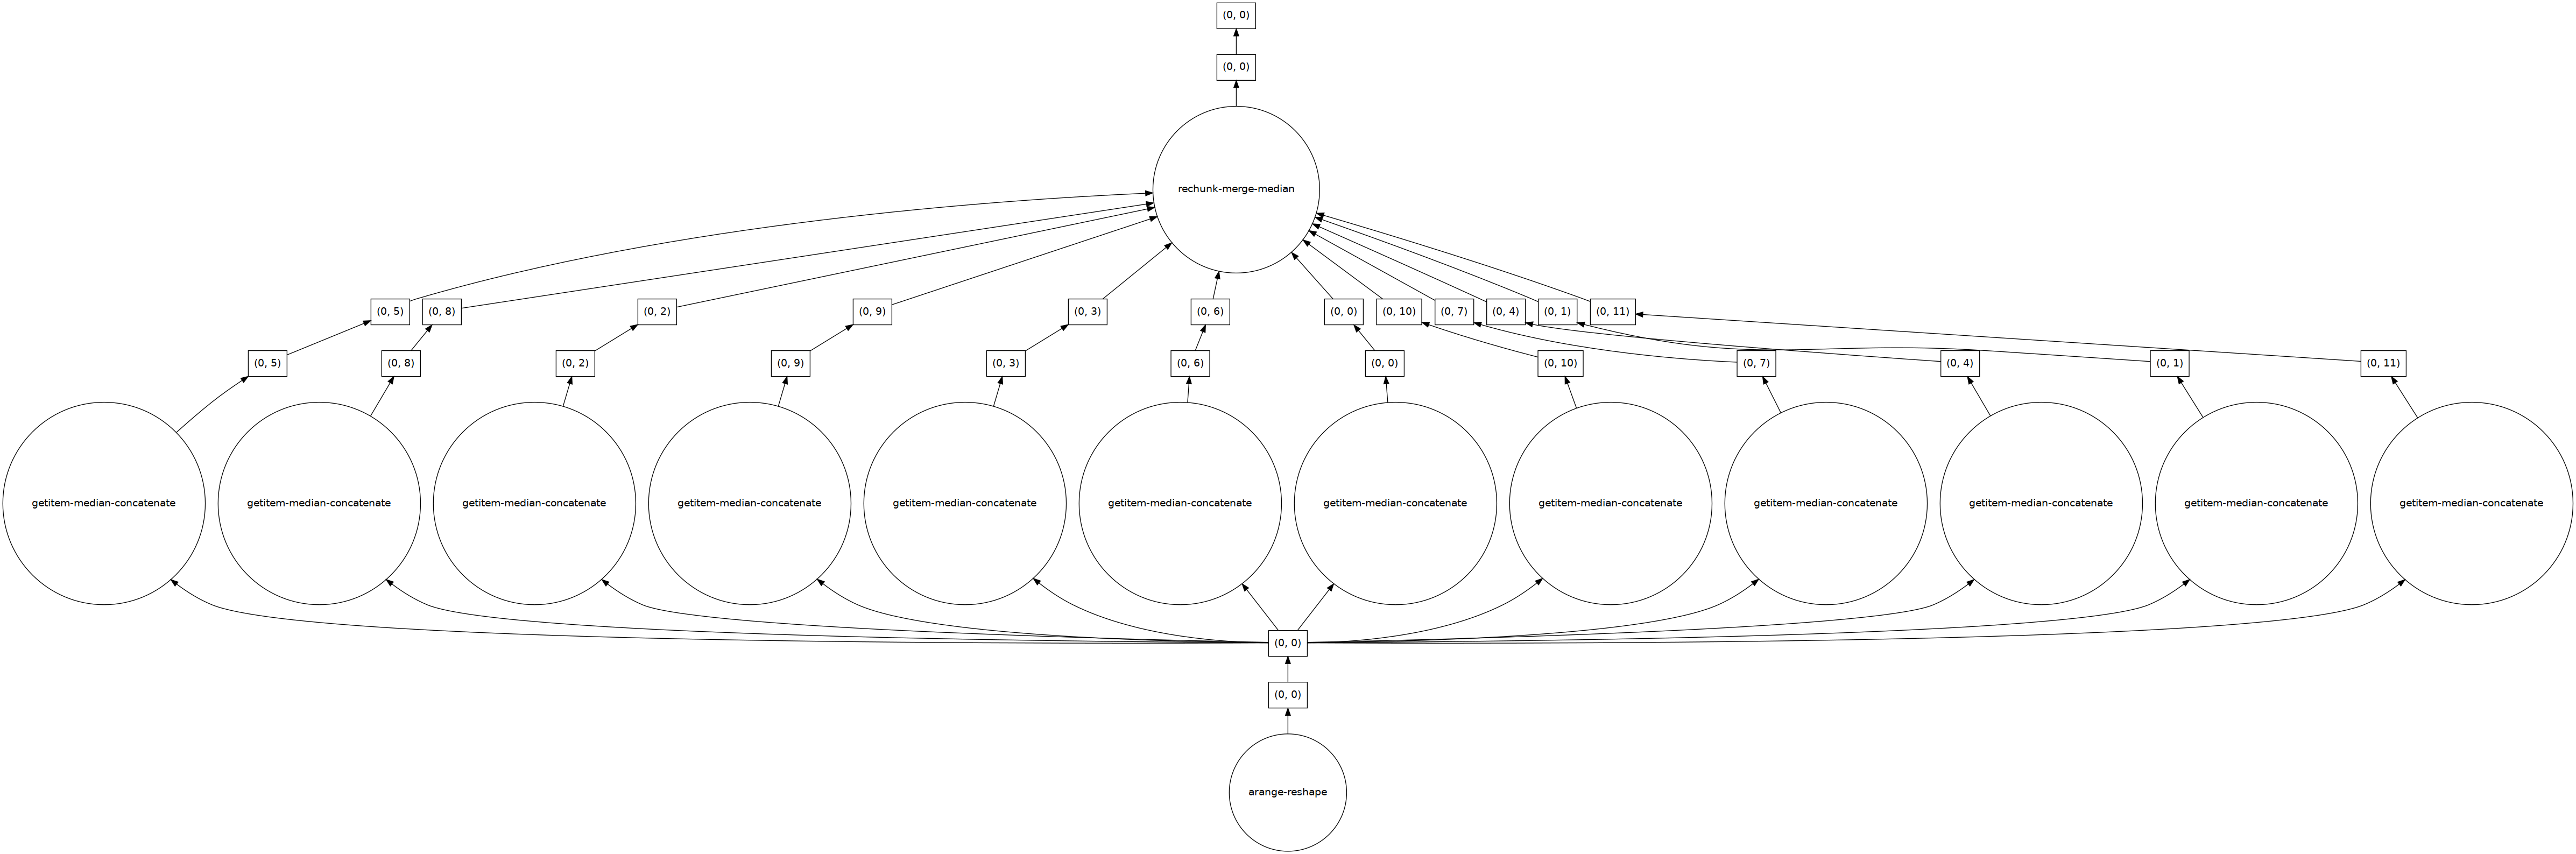

In [15]:
hm = HierarchicalMedian()
hm(da.arange(2600).reshape(20, 130)).visualize(optimize_graph=True)

In [16]:
import pycsou.util

timings = dict()
for xp in supported_array_modules():
    t1 = t.time()
    out = compute(hm.apply(xp.arange(2600).reshape(20, 130)))
    timings[xp.__name__] = t.time()-t1
print(timings)    

{'dask.array': 0.019516944885253906, 'cupy': 0.010744333267211914, 'numpy': 0.0007131099700927734}


## Comparison with Competing Computational Imaging Frameworks


<p align="center">
<img src="doc/images/comparison_soa.jpg" alt= “” width=75%>
</p>

# Demo: Multi-Modal Image Reconstruction for Computational Photography

This example considers a *multi-modal imaging* setup, where a given scene is observed with two low-end cameras.

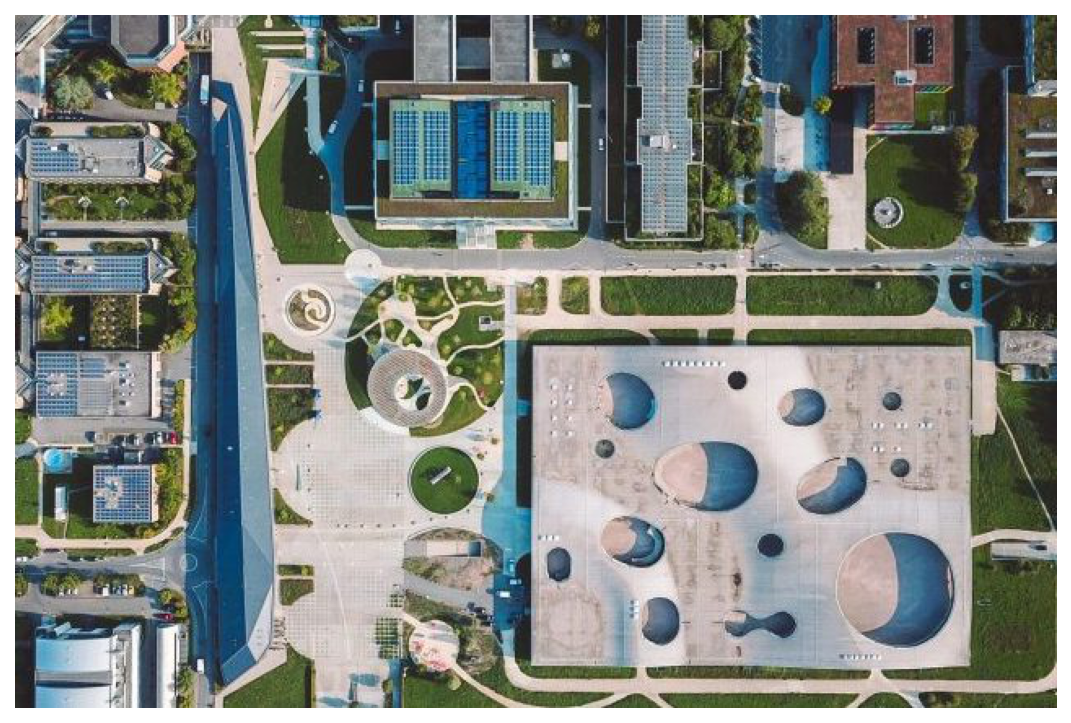

In [17]:
# Load and display input image
xp = np # Compute backend
gpu = True if xp == cp else False
image = xp.asarray(skimage.io.imread("doc/images/image.jpg", as_gray=False)).astype(np.float64)/255
image = xp.moveaxis(image, -1, 0)
imshow(image)

### Lensed photography

The first camera is a *lens camera*, with low-resolution, severe blur but good exposure and white balance.

In [18]:
from pycsou.operator import Stencil, SubSample

# Lens' PSF
wsize= 11
filt = xp.asarray(scipy.signal.get_window('hamming', wsize)); filt/= filt.sum()
Lens = Stencil(kernel=[xp.array([1.]), filt, filt], 
               center=(0, wsize//2, wsize//2), 
               arg_shape=image.shape, 
               mode='constant')

# Downsampling by 2
DownSample = SubSample(image.shape, slice(None), slice(0, None, 2), slice(0, None, 2))

# Composite operator
DownSampledLens = DownSample * Lens

# Simulate data
data_lens = DownSampledLens(image.ravel()) # Convolution with PSF
downsampled_shape = (3, image.shape[1]//2, image.shape[2]//2) 
print(DownSampledLens.expr()) # expr() keeps track of the operator algebra operations 

[compose, ==> LinOp(204480, 817920)
.SubSample(204480, 817920),
.Stencil(817920, 817920)]



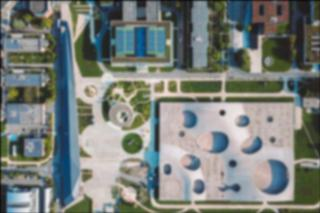
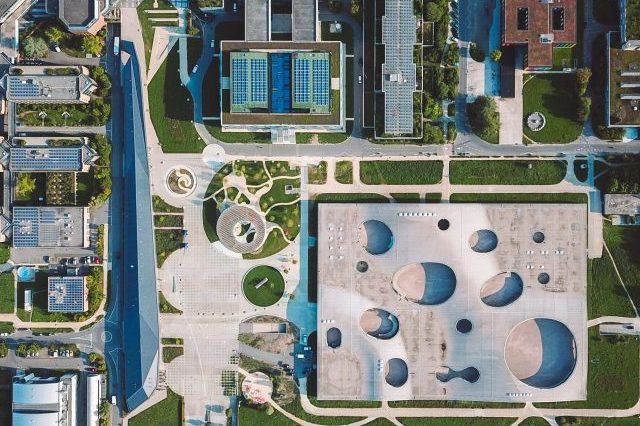

In [15]:
imshow_compare(data_lens.reshape(downsampled_shape), image, start_mode="circle") 

### Benchmark: Convolution with Pycsou vs. SciPy

The ``Stencil`` class leverages Numba JIT-compiled kernels to perform the convolution operation, allowing it to be much faster than SciPy's ``scipy.ndimage.convolve``:

In [19]:
_ = Lens(image.ravel())

In [20]:
from pylops.signalprocessing import Convolve2D # Uses SciPy as a backend for convolution

Lens_scipy = from_sciop(LinOp, Convolve2D(dims=image.shape, 
                                          h=to_NUMPY(xp.outer(filt, filt)), 
                                          offset=to_NUMPY(xp.array([wsize//2, wsize//2])), 
                                          axes=(1,2), 
                                          method='direct'))
_ = Lens_scipy(to_NUMPY(image.ravel()))

> **10 ms vs. 2 s: ~200 times faster!**

### Pinhole photography

The second camera is a *pinhole camera*, with high-resolution and no blur but very bad exposure, wrong white balance and faulty sensor pixels.

In [21]:
from pycsou.operator import block_diag, HomothetyOp, DiagonalOp
# Channel gains 
channel_gains = 0.4, 0.6, 0.2
Gains = block_diag([HomothetyOp(gain, dim=np.prod(image.shape[1:])) for gain in channel_gains])

# Tapering
taper = xp.outer(xp.asarray(scipy.signal.get_window('tukey', image.shape[1])), 
                 xp.asarray(scipy.signal.get_window('tukey', image.shape[2]))
                )
Taper = DiagonalOp(xp.tile(taper.ravel(),reps=(3,1)).ravel())

# Partial Masking 
mask = xp.ones(image.shape)
mask[:, 100:250, 200:300] = 0.1
mask[:, 250:300, 400:450] = 0.3
mask[:, 300:350, 150:200] = 0.5
Mask = DiagonalOp(mask.ravel())

# Compose operators
MaskedPinhole = Mask * Taper * Gains

# Simulate data and corrupt by shot noise
data_pinhole = MaskedPinhole(image.ravel()) 
rng = xp.random.default_rng()
data_pinhole = xp.clip(rng.standard_normal(data_pinhole.size) * xp.sqrt(data_pinhole)/4 + data_pinhole, 
                       a_min=0, a_max=1)

print(MaskedPinhole.expr())

[compose, ==> SquareOp(817920, 817920)
.[compose, ==> SquareOp(817920, 817920)
..DiagonalOp(817920, 817920),
..DiagonalOp(817920, 817920)],
.[block_diag, ==> PosDefOp(817920, 817920)
..HomothetyOp(272640, 272640),
..HomothetyOp(272640, 272640),
..HomothetyOp(272640, 272640)]]



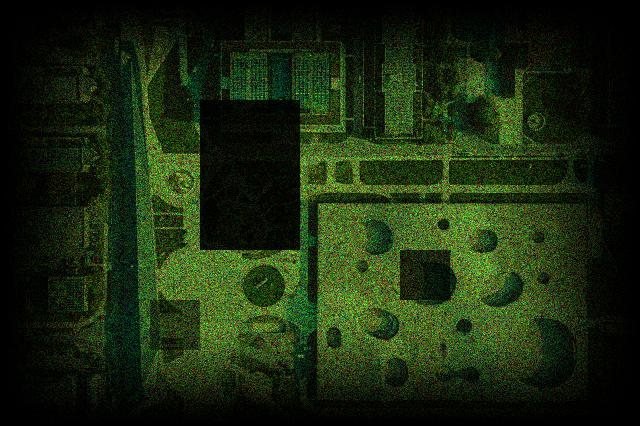
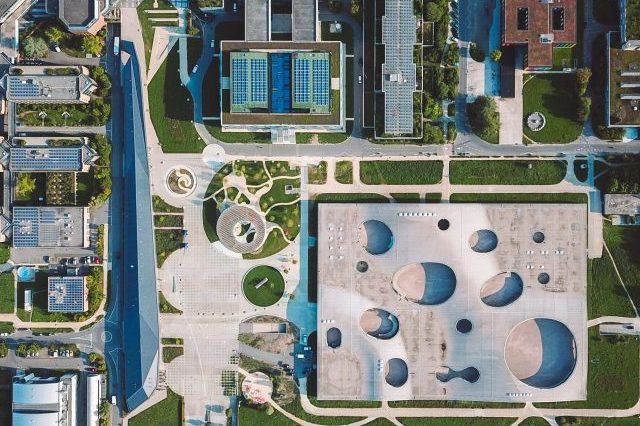

In [19]:
imshow_compare(data_pinhole.reshape(image.shape), image, start_mode="circle")

## (Dampened) Pseudo-Inverse Solution

We first consider a *linear* image reconstruction algorithm based on the *pseudo-inverse with dampening an re-weighting*:

$$ \hat{x}=\left(\theta_L^2 L^\ast L + \theta_P^2 P^\ast P + \mu I\right)^{-1}\left(\theta_L^2 L^\ast y_L +\theta_P^2 P^\ast  y_P\right)$$

where $\theta_L, \theta_P \in [0,1]$ are weights controlling the relative importance of the lens and pinhole images, and $\mu>0$ is a dampening parameter ensuring numerical stability of the procedure. 

In [22]:
from pycsou.operator import vstack

theta = 0.85, 0.15 # Weights for lens and pinhole images respectively

# Stack sensing operators and data
MultiModalOp = vstack([theta[0] * DownSampledLens,theta[1] * MaskedPinhole])
data = np.concatenate([theta[0] * data_lens, theta[1] * data_pinhole], axis=-1)

# Compute pseudo-inverse
pinv = MultiModalOp.pinv(data, damp=0.01, # Dampening factor mu
                         kwargs_init=dict(show_progress=False, verbosity=15))

INFO: [2023-03-28 13:48:20.444135] Iteration 0
	iteration: 0
	AbsError[residual]: 86.96566112143537
	N_iter: 1.0
INFO: [2023-03-28 13:48:20.832740] Iteration 15
	iteration: 15
	AbsError[residual]: 0.003481558591778391
	N_iter: 16.0
INFO: [2023-03-28 13:48:21.022252] Iteration 23
	iteration: 23
	AbsError[residual]: 8.011818075029193e-05
	N_iter: 24.0
INFO: [2023-03-28 13:48:21.022956] Stopping Criterion satisfied -> END



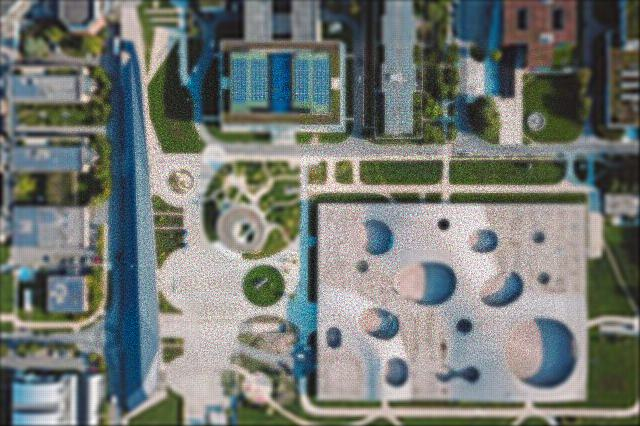
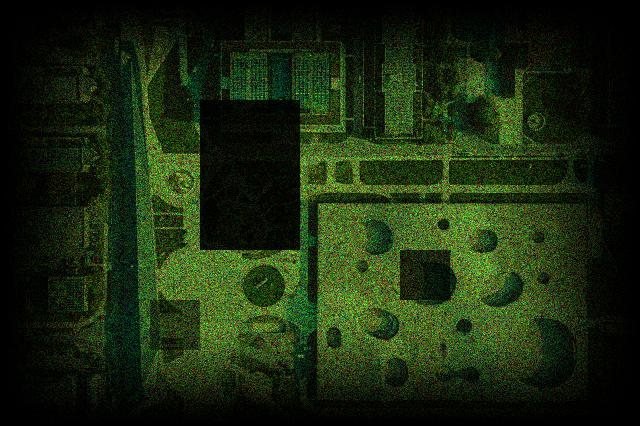

In [21]:
imshow_compare(pinv.reshape(image.shape), 
               #data_lens.reshape(downsampled_shape),
               data_pinhole.reshape(image.shape),
               #image, 
               start_mode="horizontal")

## Bayesian Image Reconstruction

We consider least-squares/Huber Losses for the lens/pinhole images respectively, and a multi-channel isotropic TV prior with range constraint. 

$$\hat{x}\in \arg\min_{x\in\mathbb{R}^{N\times M\times 3}} \theta_L\|y_L - L x\|_2^2 + \theta_P\rho_H(y_P- P x) + \lambda\|\nabla x\|_{2,1} + \chi_{[0,1]}(x)$$

In [22]:
from pycsou.abc import ProxFunc

# Range constraint functional
class RangeConstraint(ProxFunc):
    def __init__(self, dim):
        super().__init__(shape=(1, dim))
        
    @enforce_precision('arr')
    def apply(self, arr):
        return 0. if xp.alltrue((0 <= arr) * (arr <= 1)) else xp.infty
    
    @enforce_precision('arr')
    def prox(self, arr, tau):
        return arr.clip(0, 1)

### Definition of the likelihood and priors

In [23]:
from pycsou.operator import Gradient, block_diag, L21Norm, SquaredL2Norm, L1Norm

# Define multi-channel TV prior
grad = Gradient.finite_difference(arg_shape=image.shape[1:], accuracy=4, mode='constant', gpu=gpu)
jacobian = block_diag([grad, grad, grad])
jacobian.lipschitz(tight=True, tol=0.1, gpu=gpu)
lambda_= .005
l21_norm = lambda_ * L21Norm(arg_shape=(3,2) + image.shape[1:], l2_axis=(0, 1))

# Range constraint
range_constraint = RangeConstraint(image.size)

# Losses
theta = 10,0.006
loss_lens = SquaredL2Norm(dim=data_lens.size).argshift(-data_lens.ravel()) * DownSampledLens
loss_pinhole = L1Norm(dim=data_pinhole.size).moreau_envelope(0.01).argshift(-data_pinhole.ravel()) * MaskedPinhole
loss = theta[0] * loss_lens + theta[1] * loss_pinhole
beta = loss.diff_lipschitz(tight=True, tol=0.1, gpu=gpu)

### Initialization of the solver

In [24]:
from pycsou.opt.stop import RelError, MaxIter
from pycsou.opt.solver import CondatVu

# Stopping criterion
default_stop_crit = (RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) &
                     RelError(eps=1e-3, var="z", f=None, norm=2, satisfy_all=True) &
                     MaxIter(20)) | MaxIter(1000)

# Initialize solver (Condat-Vu primal-dual splitting algorithm in this case)
solver = CondatVu(f=loss, g=range_constraint, h=l21_norm, K=jacobian, show_progress=False, verbosity=100,
                  beta=beta)

# Fit  
solver.fit(x0=pinv.ravel(), tuning_strategy=2, stop_crit=default_stop_crit)
mc_isotv = solver.solution().squeeze()

INFO: [2023-03-28 10:17:42.191897] Iteration 0
	iteration: 0
	RelError[x]: 0.0
	RelError[z]: 0.0
	N_iter: 1.0
INFO: [2023-03-28 10:17:49.795249] Iteration 100
	iteration: 100
	RelError[x]: 0.0018978562909276824
	RelError[z]: 0.029591050348162392
	N_iter: 101.0
INFO: [2023-03-28 10:17:57.410726] Iteration 200
	iteration: 200
	RelError[x]: 0.0002549276207825648
	RelError[z]: 0.006877887802761634
	N_iter: 201.0
INFO: [2023-03-28 10:18:05.023583] Iteration 300
	iteration: 300
	RelError[x]: 0.00012832037578172105
	RelError[z]: 0.0040394154838567335
	N_iter: 301.0
INFO: [2023-03-28 10:18:13.490630] Iteration 400
	iteration: 400
	RelError[x]: 7.109902437876397e-05
	RelError[z]: 0.002705417562685653
	N_iter: 401.0
INFO: [2023-03-28 10:18:23.285455] Iteration 500
	iteration: 500
	RelError[x]: 4.676885957334725e-05
	RelError[z]: 0.0012175990471328963
	N_iter: 501.0
INFO: [2023-03-28 10:18:26.604576] Iteration 539
	iteration: 539
	RelError[x]: 4.1340964454998626e-05
	RelError[z]: 0.00099955316380


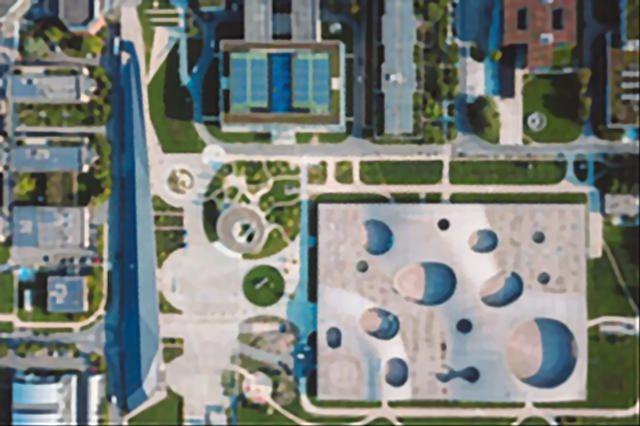
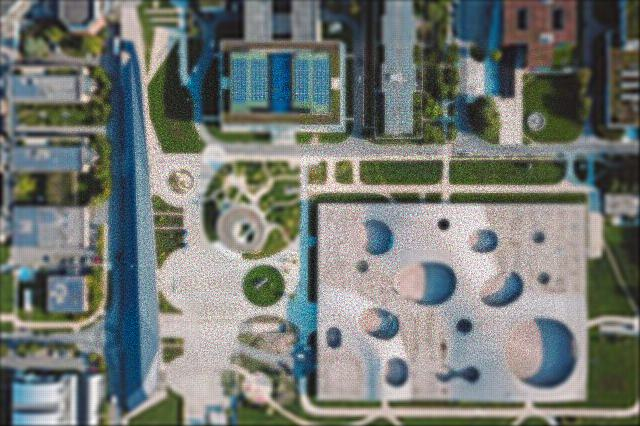

In [25]:
imshow_compare(mc_isotv.reshape(image.shape), 
               pinv.reshape(image.shape),
               #data_lens.reshape(downsampled_shape),
               #data_pinhole.reshape(image.shape),
               #image, 
               start_mode="horizontal")

## Plug-and-Play Reconstruction

Alternatively, one can consider a reconstruction scheme involving an implicit *plug-and-play prior*, defined as a denoiser:  

$$x_{n+1} = \text{denoiser}_\rho(x_n-\tau \nabla \ell(x_n; y_L, y_P)), \qquad n\geq 0$$

where 

$$\ell(x; y_L, y_P)=\theta_L\|y_L - L x\|_2^2 + \theta_P\rho_H(y_P- P x).$$ 

### Median filter PnP prior

In [26]:
from pycsou.util.deps import NDArrayInfo
import scipy.ndimage as cpu_ndimage
import cupyx.scipy.ndimage as gpu_ndimage
xp_median_filter = {NDArrayInfo.CUPY: gpu_ndimage.median_filter, NDArrayInfo.NUMPY: cpu_ndimage.median_filter}

class MedianFilter(ProxFunc):
    def __init__(self, dim, filter_size=3, arg_shape=-1):
        super().__init__(shape=(1, dim))
        self._filter_size = filter_size
        self._arg_shape = arg_shape
        
    def apply(self,arr):
        return NotImplemented
        
    def prox(self, arr, tau=None):
        return xp_median_filter[NDArrayInfo.from_obj(arr)](arr.reshape(self._arg_shape),
                                                           size=self._filter_size).ravel()
            

MF = MedianFilter(image.size,arg_shape=image.shape, filter_size=(1, 3, 3)) 

In [31]:
from pycsou.opt.solver import PGD

solver = PGD(f=loss, g=MF, show_progress=False, verbosity=100)
solver.fit(x0=0*pinv.ravel(), tau = 1./beta, 
           acceleration=True, stop_crit=MaxIter(250))
red_median = solver.solution().squeeze()

INFO: [2023-03-28 10:19:51.384547] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO: [2023-03-28 10:19:59.393509] Iteration 100
	iteration: 100
	N_iter: 101.0
INFO: [2023-03-28 10:20:08.365955] Iteration 200
	iteration: 200
	N_iter: 201.0
INFO: [2023-03-28 10:20:12.644191] Iteration 250
	iteration: 250
	N_iter: 251.0
INFO: [2023-03-28 10:20:12.644798] Stopping Criterion satisfied -> END



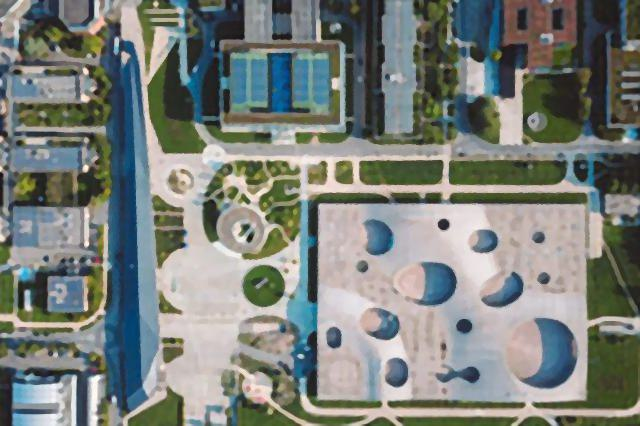
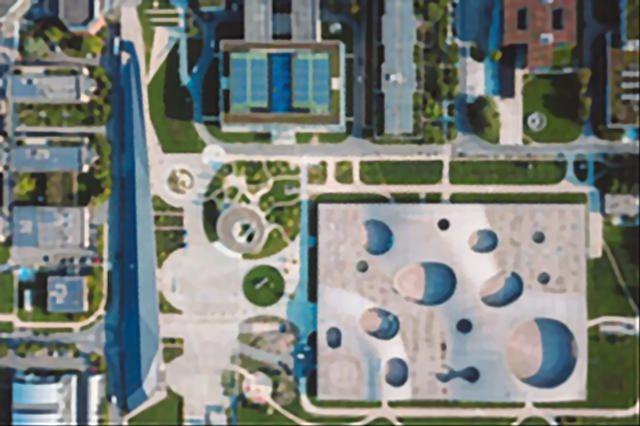

In [32]:

imshow_compare(red_median.reshape(image.shape), 
               mc_isotv.reshape(image.shape), 
               #pinv.reshape(image.shape),
               #data_lens.reshape(downsampled_shape),
               #data_pinhole.reshape(image.shape),
               #image, 
               start_mode="horizontal")

## Interoperability with PyTorch

Pycsou is interoperable with major deep learning frameworks such as PyTorch, allowing its users to benefit from the latest incursions of deep learning in the field of computational imaging (e.g., PnP methods, unrolled neural networks, deep generative priors). This is achieved by means of zero-copy data exchange via the ``__cuda_array_interface__`` protocol.

The function ``pycsou.operator.interop.from_pytorch()`` wraps a Python function with single-element ``Tensor`` input/output as a ``Map`` or a specified subclass. 

In [23]:
xp = cp
in_size, out_size = 4000, 3000
m = torch.nn.Linear(in_size, out_size)
device = {cp: "cuda", np: "cpu"}
if xp == cp:
    m = m.cuda()
op = from_pytorch(lambda x: m(x), shape=(out_size, in_size), name="TorchOp", base=Map, meta=m)
print(op.expr())

[from_pytorch, ==> TorchOp(3000, 4000)
.Linear(in_features=4000, out_features=3000, bias=True)]


In [25]:
arr = xp.ones(in_size, dtype=np.float32)
arr_t = torch.ones(in_size, dtype=torch.float32, device=device[xp])
with Precision(Width.SINGLE):
    t1 = t.time()
    y1 = op(arr)
    print(f"{t.time()-t1} seconds ellapsed (Pycsou wrapper)")
t1 = t.time()
with torch.inference_mode():
    y2 = m(arr_t)
print(f"{t.time() - t1} seconds ellapsed (Pytorch)")
assert xp.allclose(y1, _TorchWrapper._asarray(y2), atol=1e-4)

0.0009021759033203125 seconds ellapsed (Pycsou wrapper)
0.0003781318664550781 seconds ellapsed (Pytorch)


For subclasses of ``DiffMap`` the methods ``DiffMapjacobian``,
``DiffFunc.grad`` are defined implicitly using the auto-differentiation transforms from the module ``torch.func``of PyTorch. 


> Transforms in ``torch.func`` work well on pure functions (that is, functions where the output is completely determined by the input and that do not involve side effects like mutation), but may fail on more complex functions. Moreover, the ``torch.func`` module does not yet have full coverage over PyTorch operations.

In [26]:
op = from_pytorch(lambda x: m(x), shape=(out_size, in_size), name="TorchOp", base=DiffMap, meta=m)
with Precision(Width.SINGLE):
    jac = op.jacobian(arr)
print(jac.expr())

[autojac_from_pytorch, ==> AutoJacOp(3000, 4000)
.[from_pytorch, ==> TorchOp(3000, 4000)
..Linear(in_features=4000, out_features=3000, bias=True)]]


In [27]:
with Precision(Width.SINGLE):
    jac_mat = jac.apply(xp.eye(in_size, dtype=np.float32))
    jac_matT = jac.adjoint(xp.eye(out_size, dtype=np.float32))

assert xp.allclose(jac_mat, _TorchWrapper._asarray(m.weight.transpose(0, 1)), atol=1e-4)
assert xp.allclose(jac_matT, _TorchWrapper._asarray(m.weight), atol=1e-4)

Composition with  other Pycsou operators works flawlessly: 

In [28]:
loss = SquaredL2Norm(dim=op.shape[0]) * op
print(loss.expr())

[compose, ==> DiffFunc(1, 4000)
.SquaredL2Norm(1, 3000),
.[from_pytorch, ==> TorchOp(3000, 4000)
..Linear(in_features=4000, out_features=3000, bias=True)]]


In [29]:
mat = _TorchWrapper._asarray(m.weight)
z = xp.ones(in_size, dtype=np.float32)
with Precision(Width.SINGLE):
    grad = loss.grad(z)    
assert xp.allclose(grad, 2 * mat.T @ (mat @ z), atol=1e-1)

You can also differentiate w.r.t. the model parameters as follows:

In [30]:
m_small = torch.nn.Linear(10, 20)
device = {cp: "cuda", np: "cpu"}
if xp == cp:
    m_small = m_small.cuda()

def f(w):
    return torch.func.functional_call(m_small, {'weight': torch.reshape(w, m_small.weight.shape)}, 
                                      torch.ones(10, dtype=torch.float32, device=device[xp]))

op = from_pytorch(f, shape=(20, np.prod(m_small.weight.size())), name="TorchOp", base=DiffMap, meta=m_small)
print(op.expr())

[from_pytorch, ==> TorchOp(20, 200)
.Linear(in_features=10, out_features=20, bias=True)]


In [15]:
with Precision(Width.SINGLE):
    _ = op(xp.ones(op.shape[1]))
    jac = op.jacobian(xp.ones(op.shape[1]))

It is also possible to compute the adjoint of linear operators automatically via automatic-differentiation. 
For a linear operator ``L`` we have indeed ``L.jacobian(arr)==L`` for any input ``arr``. Given its apply method, the
           adjoint of ``L`` can hence be computed via automatic-differentiation as ``L.adjoint(arr) = L.jacobian(arr).adjoint(arr)``.

In [17]:
m = torch.nn.Linear(in_size, out_size, bias=False)
if xp == cp:
    m = m.cuda()

op = from_pytorch(lambda x: m(x), shape=(out_size, in_size), name="TorchOp", base=LinOp, meta=m)

with Precision(Width.SINGLE): 
    assert xp.allclose(op.adjoint(xp.eye(out_size, dtype=np.float32)), _TorchWrapper._asarray(m.weight), atol=1e-4)